# Similar to 2.boostrap.ipynb but make sure the same records are sampled from prevalence vs exposure

Plot the change in exposure reduction  
We need to get the message info for removal=False and removal=True, respectively.
However, since illegal and normal messages have the same appeal, the normal messages in the removal=True scenario can be used instead of the baseline as described, i.e., illegal messages in the removal=False scenario.

Calculate approximate confidence interval of ratio using Fieller's method 

https://mverbakel.github.io/2021-03-05/confidence-intervals


In [1]:
import simsom.utils as utils
import numpy as np
import pandas as pd
import os
import glob
import matplotlib.pyplot as plt

## Helpers

the percentage difference is mean(moderated) - mean(baseline) / mean(baseline)

In [2]:
def get_agg_metric(
    df,
    group_key="base_name",
    new_col_prefix="baseline",
    metrics=[
        "quality",
        "illegal_frac",
        "unique_illegal_frac",
        "illegal_count",
        "unique_illegal_count",
    ],
):
    """
    Return a df where the columns of interest are aggregated by mean and std & renamed (prefix with a phrase)
    new_col_prefix (str): the prefix to append to aggregated cols
    """
    if "illegal_prob" not in df.columns:
        raise ValueError(
            "`illegal_prob` column not found in the dataframe. This is needed as a dummy column to count the number of observations."
        )
    for metric in metrics:
        df[f"{metric}_std"] = df[metric]
        df = df.rename(columns={metric: f"{metric}_mean"})

    # aggregate (by mean or std)
    agg = dict()
    agg["illegal_prob"] = "count"
    for metric in metrics:
        agg[f"{metric}_mean"] = "mean"
        agg[f"{metric}_std"] = "std"
    try:
        agg_df = df.groupby(group_key).agg(agg).reset_index()
        # rename aggregated cols with the prefix
        agg_cols = (
            [f"{metric}_mean" for metric in metrics]
            + [f"{metric}_std" for metric in metrics]
            + ["illegal_prob"]
        )
        rename_dict = {col: f"{new_col_prefix}_{col}" for col in agg_cols}
        rename_dict["illegal_prob"] = f"{new_col_prefix}_no_observations"
        agg_df = agg_df[agg_cols + [group_key]].rename(columns=rename_dict)
    except Exception as e:
        print(e)
        raise ValueError(
            "Unable to groupby or rename col, most likely the specified group_key or retain_cols don't exist."
        )
    return agg_df


def get_delay_from_name(string):
    # 4_0.01__diff_true -> 4
    delay = string.split("__")[0].split("_")[0]
    if delay != "b":
        return float(delay)
    else:
        return -1

# Prevalence 

In [3]:
fpaths = glob.glob(
    "/N/u/baotruon/BigRed200/carisma/experiments/20241126_main_results/prevalence*/*.parquet"
)
dfs = []
print("No fpaths: ", len(fpaths))
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    if "vary_half_life_algo" in fpath:
        continue
    raw = pd.read_parquet(fpath).reset_index()
    raw = raw.drop(columns=["index"])
    dfs.append(raw)
data = pd.concat(dfs)

No fpaths:  61
Processing 0/61
Processing 5/61
Processing 10/61
Processing 15/61
Processing 20/61
Processing 25/61
Processing 30/61
Processing 35/61
Processing 40/61
Processing 45/61
Processing 50/61
Processing 55/61
Processing 60/61


In [4]:
data["base_name"] = data["fpath"].apply(
    lambda x: os.path.basename(x).replace(".json.gz", "")
)
# Name could be  '1_0.01__diff_true--EXTRA--EXTRA--1--1.json.gz' or '4_0.01__diff_true_1'
# We want to infer illegal prob '8_0.001__diff_true--1.json.gz' -> 0.001
data["illegal_prob"] = data["base_name"].apply(lambda x: x.split("_")[1])
print("Data shape:", data.shape)
data = data[data["illegal_prob"] == "0.01"]
print("Filter only illegal prob 0.01, shape:", data.shape)

data.head()

Data shape: (1116, 11)
Filter only illegal prob 0.01, shape: (991, 11)


,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,fpath,moderation_half_life,quality,graph_gml,no_steps,base_name,illegal_prob
0,0.006931,0.008555,1039,45,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-1.000000,/N/project/simsom/carisma/04302024_illegal_rem...,156,b_0.01__diff_true_1,0.01
1,0.009853,0.009147,1477,46,/N/project/simsom/carisma/04302024_illegal_rem...,16.0,-0.999999,/N/project/simsom/carisma/04302024_illegal_rem...,134,4_0.01__diff_true_2,0.01
2,0.009352,0.008408,1402,45,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-1.000000,/N/project/simsom/carisma/04302024_illegal_rem...,1344,b_0.01__diff_true_2,0.01
3,0.011944,0.010405,1790,55,/N/project/simsom/carisma/04302024_illegal_rem...,32.0,-0.999983,/N/project/simsom/carisma/04302024_illegal_rem...,111,5_0.01__diff_true_2,0.01
4,0.041925,0.011924,6285,60,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-0.999992,/N/project/simsom/carisma/04302024_illegal_rem...,118,b_0.01__diff_true,0.01


In [5]:
data["half_life"] = data.apply(
    lambda row: -1 if "b_" in row["base_name"] else row["moderation_half_life"], axis=1
)

In [6]:
data.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,fpath,moderation_half_life,quality,graph_gml,no_steps,base_name,illegal_prob,half_life
0,0.006931,0.008555,1039,45,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-1.000000,/N/project/simsom/carisma/04302024_illegal_rem...,156,b_0.01__diff_true_1,0.01,-1.0
1,0.009853,0.009147,1477,46,/N/project/simsom/carisma/04302024_illegal_rem...,16.0,-0.999999,/N/project/simsom/carisma/04302024_illegal_rem...,134,4_0.01__diff_true_2,0.01,16.0
2,0.009352,0.008408,1402,45,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-1.000000,/N/project/simsom/carisma/04302024_illegal_rem...,1344,b_0.01__diff_true_2,0.01,-1.0
3,0.011944,0.010405,1790,55,/N/project/simsom/carisma/04302024_illegal_rem...,32.0,-0.999983,/N/project/simsom/carisma/04302024_illegal_rem...,111,5_0.01__diff_true_2,0.01,32.0
4,0.041925,0.011924,6285,60,/N/project/simsom/carisma/04302024_illegal_rem...,512.0,-0.999992,/N/project/simsom/carisma/04302024_illegal_rem...,118,b_0.01__diff_true,0.01,-1.0


# simplify 

In [7]:
# data = data.sort_values(by=["fpath"]).reset_index(drop=True)
retain_cols = [
    "illegal_frac",
    "unique_illegal_frac",
    "illegal_count",
    "unique_illegal_count",
    "illegal_prob",
    "half_life",
]
data = data[retain_cols]
data.head()

,illegal_frac,unique_illegal_frac,illegal_count,unique_illegal_count,illegal_prob,half_life
0,0.006931,0.008555,1039,45,0.01,-1.0
1,0.009853,0.009147,1477,46,0.01,16.0
2,0.009352,0.008408,1402,45,0.01,-1.0
3,0.011944,0.010405,1790,55,0.01,32.0
4,0.041925,0.011924,6285,60,0.01,-1.0


## Count number of observations for each param
###  Baseline

In [8]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
data[data.half_life == -1].groupby("illegal_prob").size()

illegal_prob
0.01    73
dtype: int64

### Non-baseline

In [9]:
# Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
row_counts = (
    data[~(data.half_life == -1)]
    .groupby(["half_life"])
    .size()
    .reset_index(name="count")
)

# Display the result
row_counts.sort_values(by=["half_life"])

,half_life,count
0,0.0625,50
1,0.1250,54
2,0.2500,50
3,0.5000,56
4,1.0000,73
5,2.0000,74
6,4.0000,70
7,8.0000,71
8,16.0000,70
9,32.0000,70


## Agg baseline results

In [10]:
result = data
retain_cols = ["unique_illegal_frac", "illegal_prob", "half_life"]

print("Filtering none-baseline results...")
res = result[result.half_life != -1][retain_cols]

Filtering none-baseline results...


In [11]:
# BASELINE
print("Filter baseline results...")
baseline = result[result.half_life == -1]["unique_illegal_frac"]
# bootstrap sample baseline to get the same number of samples as the treatment
# baseline = baseline.sample(n=res.shape[0], replace=True, random_state=0)

Filter baseline results...


# Check normality of distribution

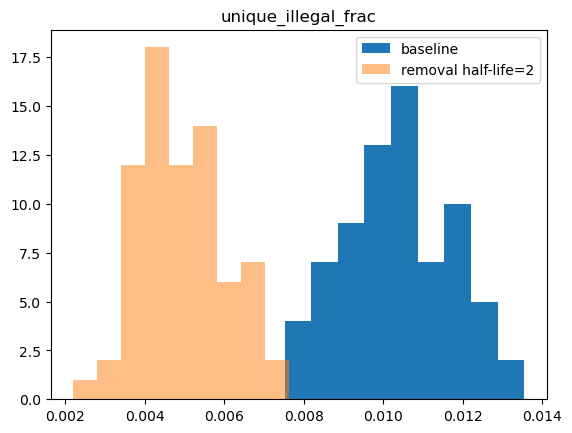

In [12]:
import matplotlib.pyplot as plt

halflife = 2
plt.hist(baseline, bins="rice", label="baseline")
plt.hist(
    res[res.half_life == 2]["unique_illegal_frac"],
    bins="rice",
    alpha=0.5,
    label="removal half-life=2",
)
plt.title("unique_illegal_frac")
plt.legend()

plt.savefig("eda/unique_illegal_frac.png")

# Bootstrap

In [12]:
def get_pct_change(baseline, treatment):
    # Calculate means
    mean_base = np.mean(baseline)
    return (treatment - mean_base) / mean_base

In [13]:
import numpy as np

np.sqrt(50)

7.0710678118654755

In [14]:
from scipy import stats
from tqdm import tqdm
import numpy as np

# FIX NO RECORDS TO 50

raw_bootstrap = []
bootstrap_res = []
metric = "unique_illegal_frac"
for half_life in res.half_life.unique():
    print(f"Processing half_life: {half_life}")
    half_life_group = res[res.half_life == half_life]
    # make sure 2 groups have the same number of records
    no_records = min(
        half_life_group.shape[0], baseline.shape[0]
    )  # uncomment if using all records
    baseline_vals = baseline[:no_records]
    removal = half_life_group[:no_records][metric]
    # no_records = 50
    # baseline_vals = baseline.sample(n=no_records, replace=False, random_state=0)
    # removal = half_life_group.sample(n=no_records, replace=False, random_state=0)[
    #     metric
    # ]
    # create bootstrap sample of pair of observations
    pct_changes = []
    for i in tqdm(range(100), desc=f"Bootstrap half_life={half_life}"):

        bs_removal = removal.sample(n=no_records, replace=True, random_state=0)
        bs_baseline = baseline_vals.sample(n=no_records, replace=True, random_state=0)
        pct_change = get_pct_change(bs_baseline, bs_removal)
        record = {
            "bs_removal": bs_removal,
            "bs_baseline": bs_baseline,
            "pct_changes": pct_changes,
            "half_life": half_life,
        }
        raw_bootstrap.append(record)
        pct_changes.append(pct_change)
    print("Calculate bootstrap statistics...")
    pct_changes = np.array(pct_changes)
    mu, sigma = np.mean(pct_changes), pct_changes.std(ddof=1)
    N = len(pct_changes)
    std = np.std(pct_changes)
    ci = stats.norm.interval(0.95, loc=mu, scale=sigma / np.sqrt(N))
    print(f"Mean: {mu}, Std: {std}, CI: {ci}")
    bootstrap_res.append(
        {
            "half_life": half_life,
            "pct_mean": mu,
            "std": std,
            "lower": ci[0],
            "upper": ci[1],
        }
    )

Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1644.31it/s]


Calculate bootstrap statistics...
Mean: -0.08149330267687097, Std: 0.09396021601462026, CI: (-0.09991048217350404, -0.06307612318023789)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1645.15it/s]


Calculate bootstrap statistics...
Mean: -0.02662384811985556, Std: 0.10654765789940333, CI: (-0.04750829713148651, -0.005739399108224616)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1679.64it/s]


Calculate bootstrap statistics...
Mean: 0.02268056860121284, Std: 0.09022264871876422, CI: (0.004995991164134579, 0.040365146038291104)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1659.02it/s]


Calculate bootstrap statistics...
Mean: -0.7065514652019153, Std: 0.05585179108723693, CI: (-0.7174989649566503, -0.6956039654471802)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1674.23it/s]


Calculate bootstrap statistics...
Mean: -0.31518527505947125, Std: 0.1034368122295195, CI: (-0.3354599659679529, -0.2949105841509896)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1671.29it/s]


Calculate bootstrap statistics...
Mean: -0.004699975550331309, Std: 0.13212195061709142, CI: (-0.0305972518995219, 0.021197300798859287)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1665.99it/s]


Calculate bootstrap statistics...
Mean: -0.008996742572606305, Std: 0.11103396006401887, CI: (-0.030760553464684624, 0.012767068319472014)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1666.60it/s]


Calculate bootstrap statistics...
Mean: -0.023061637398767876, Std: 0.1327895550981835, CI: (-0.049089771169136764, 0.002966496371601013)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1654.56it/s]


Calculate bootstrap statistics...
Mean: -0.5300883507191758, Std: 0.11275382715222837, CI: (-0.552189208562149, -0.5079874928762026)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1643.04it/s]


Calculate bootstrap statistics...
Mean: -0.21735210072938344, Std: 0.14030349814319262, CI: (-0.24485301780844668, -0.1898511836503202)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1672.46it/s]


Calculate bootstrap statistics...
Mean: -0.8707582055592286, Std: 0.043905448875372156, CI: (-0.8793642838454616, -0.8621521272729955)
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1672.00it/s]


Calculate bootstrap statistics...
Mean: -0.9670048034506668, Std: 0.015817677721958627, CI: (-0.9701053213833742, -0.9639042855179593)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1665.62it/s]
/geode2/home/u015/baotruon/BigRed200/conda/envs/carisma/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2351: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/geode2/home/u015/baotruon/BigRed200/conda/envs/carisma/lib/python3.8/site-packages/scipy/stats/_distn_infrastructure.py:2352: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


Calculate bootstrap statistics...
Mean: -1.0, Std: 0.0, CI: (nan, nan)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1674.87it/s]

Calculate bootstrap statistics...
Mean: -0.9986036439059343, Std: 0.004936864616402057, CI: (-0.9995713411961537, -0.9976359466157149)


In [15]:
bootstrap_df = pd.DataFrame(bootstrap_res).sort_values(by="half_life")
bootstrap_df.head()

,half_life,pct_mean,std,lower,upper
12,0.0625,-1.000000,0.000000,NaN,NaN
13,0.1250,-0.998604,0.004937,-0.999571,-0.997636
11,0.2500,-0.967005,0.015818,-0.970105,-0.963904
10,0.5000,-0.870758,0.043905,-0.879364,-0.862152
3,1.0000,-0.706551,0.055852,-0.717499,-0.695604


In [16]:
bootstrap_df

,half_life,pct_mean,std,lower,upper
12,0.0625,-1.000000,0.000000,NaN,NaN
13,0.1250,-0.998604,0.004937,-0.999571,-0.997636
11,0.2500,-0.967005,0.015818,-0.970105,-0.963904
10,0.5000,-0.870758,0.043905,-0.879364,-0.862152
3,1.0000,-0.706551,0.055852,-0.717499,-0.695604
8,2.0000,-0.530088,0.112754,-0.552189,-0.507987
4,4.0000,-0.315185,0.103437,-0.335460,-0.294911
9,8.0000,-0.217352,0.140303,-0.244853,-0.189851
0,16.0000,-0.081493,0.093960,-0.099910,-0.063076
1,32.0000,-0.026624,0.106548,-0.047508,-0.005739


# Prevalence plot

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("stylesheet.mplstyle")
# yellow, pink, purple, blue, orange, teal
# PALETTE = ["#F8D625", "#BC3684", "#550F6B", "#3863AC", "#F18447", "#209B8A"]
# orange, purple, pink
PALETTE = ["#F18447", "#550F6B", "#BC3684"]
sns.set_palette(PALETTE)

network_suffix = "diff_true"

PLOT_DIR = "plots_20241202_bootstrap_all"
if not os.path.exists(PLOT_DIR):
    os.makedirs(PLOT_DIR)


## Helper
def draw_lines(
    ax,
    data,
    line_name="hub",
    marker="",
    linewidth=1,
    color="#F18447",
    absolute=True,
):
    """
    Input: data=(x,y, err)
    line_name=['hub', 'none']
    err: tuple of mean+error, mean-error. Could be std or CI95
    """
    x, y, y_lower, y_upper = data
    print(f"Drawing line {line_name}")
    print(f"X: {x}")
    print(f"Y: {y}")
    print(f"Y lower: {y_lower}")
    print(f"Y upper: {y_upper}")
    if absolute:
        y = np.array(y) * -1
        y_lower = np.array(y_lower) * -1
        y_upper = np.array(y_upper) * -1
    ax.plot(x, y, label=line_name, marker=marker, color=color, linewidth=linewidth)
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=color,
        alpha=0.3,
    )
    return

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Drawing line 
X: (0.0625, 0.125, 0.25, 0.5, 1.0, 2.0, 4.0, 8.0, 16.0, 32.0, 64.0, 128.0, 256.0, 512.0)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98511836503202, -6.307612318023789, -0.5739399108224617, 1.2767068319472015, 4.036514603829111, 2.1197300798859287, 0.2966496371601013)


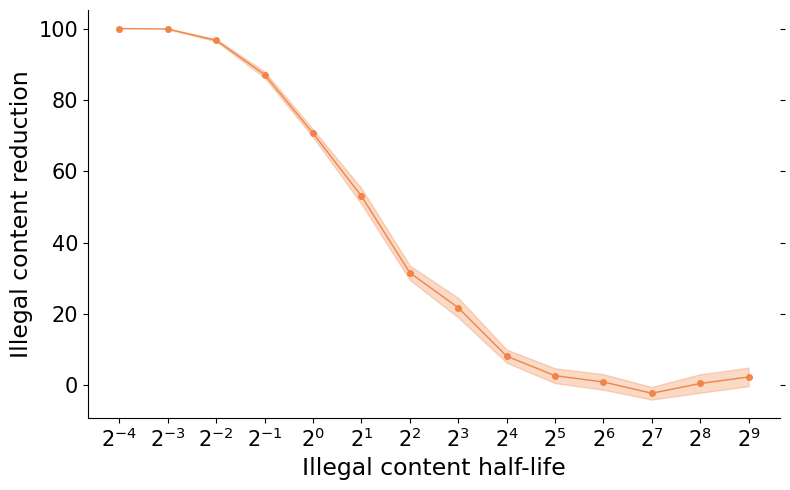

In [18]:
prevalence_df = bootstrap_df
metric_col = "pct_mean"
x_col = "half_life"
y_label = "Illegal content reduction"
x_label = "Illegal content half-life"
pct = True
log_x = True
fname = f"prevalence.png"

fig, ax = plt.subplots(figsize=(8, 5))  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
### GET DATA
max_half_life = 0

x = prevalence_df[x_col]  # content half life
y = prevalence_df[f"{metric_col}"] if not pct else prevalence_df[f"{metric_col}"] * 100
y_lower = prevalence_df["lower"] if not pct else prevalence_df["lower"] * 100
y_upper = prevalence_df["upper"] if not pct else prevalence_df["upper"] * 100
plot_data = zip(*sorted(zip(x, y, y_lower, y_upper), key=lambda x: x[0]))

draw_lines(ax, plot_data, line_name="", marker=".", color=PALETTE[0], absolute=True)

ax.set_xlabel(x_label)
ax.set_ylabel(y_label)
ax.set_xscale("log", base=2)
ax.tick_params(labelleft=True, labelright=False, left=True, right=True)
ax.xaxis.set_major_locator(plt.LogLocator(base=2, numticks=len(x) + 1))
ax.legend(loc="best", frameon=False)

# hide spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.tight_layout()

plt.savefig(f"{PLOT_DIR}/{fname}", dpi=300)

# Save prevalence data to an object

In [19]:
import pickle as pkl

# x, y, y_lower, y_upper, xticks
fpath = os.path.join(PLOT_DIR, f"prevalence_plotdata.pkl")
prevalence_plot_data = {
    "x": x,
    "y": y,
    "y_lower": y_lower,
    "y_upper": y_upper,
}
with open(fpath, "wb") as f:
    pkl.dump(prevalence_plot_data, f)

# Exposure

In [20]:
fpaths = glob.glob(
    "/N/u/baotruon/BigRed200/carisma/experiments/20241126_main_results/engagement*/*.parquet"
)
dfs = []
print("No fpaths: ", len(fpaths))
for idx, fpath in enumerate(fpaths):
    if idx % 5 == 0:
        print(f"Processing {idx}/{len(fpaths)}")
    if "vary_half_life_algo" in fpath:
        continue
    raw = pd.read_parquet(fpath).reset_index()
    raw = raw.drop(columns=["index"])
    dfs.append(raw)
exposure = pd.concat(dfs)

No fpaths:  57
Processing 0/57
Processing 5/57
Processing 10/57
Processing 15/57
Processing 20/57
Processing 25/57
Processing 30/57
Processing 35/57
Processing 40/57
Processing 45/57
Processing 50/57
Processing 55/57


In [21]:
exposure["base_name"] = exposure["fpath"].apply(
    lambda x: os.path.basename(x).replace(".json.gz", "")
)
# Name could be  '1_0.01__diff_true--EXTRA--EXTRA--1--1.json.gz' or '4_0.01__diff_true_1'
# We want to infer illegal prob '8_0.001__diff_true--1.json.gz' -> 0.001
exposure["illegal_prob"] = exposure["base_name"].apply(lambda x: x.split("_")[1])
print("exposure shape:", exposure.shape)
exposure = exposure[exposure["illegal_prob"] == "0.01"]
print("Filter only illegal prob 0.01, shape:", exposure.shape)

exposure.head()

exposure shape: (1982, 8)
Filter only illegal prob 0.01, shape: (1982, 8)


,type,no_exposures,no_reach,no_reshares,no_unique_reshares,fpath,base_name,illegal_prob
0,illegal,"[0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 99, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, ...","[1, 1, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1, ...",/N/project/simsom/carisma/04302024_illegal_rem...,11_0.01__diff_true,0.01
1,legal,"[26, 3768, 97, 31, 18, 31, 56, 16, 23, 259, 35...","[25, 2705, 93, 31, 18, 26, 56, 16, 23, 234, 35...","[3, 325, 5, 1, 1, 1, 1, 1, 1, 13, 1, 4, 5, 7, ...","[3, 307, 5, 1, 1, 1, 1, 1, 1, 13, 1, 4, 5, 7, ...",/N/project/simsom/carisma/04302024_illegal_rem...,11_0.01__diff_true,0.01
0,illegal,"[13, 17, 27, 70, 6, 586, 9, 62, 7, 2, 10, 3, 9...","[13, 17, 26, 67, 6, 486, 9, 61, 7, 2, 10, 3, 8...","[1, 1, 1, 5, 1, 45, 1, 1, 2, 1, 2, 1, 1, 6, 3,...","[1, 1, 1, 5, 1, 40, 1, 1, 2, 1, 2, 1, 1, 6, 3,...",/N/project/simsom/carisma/04302024_illegal_rem...,b_0.01__diff_true,0.01
1,legal,"[137, 66, 119, 390, 209, 443, 400, 107, 14, 37...","[137, 65, 113, 377, 198, 424, 389, 106, 14, 37...","[3, 2, 6, 5, 4, 21, 16, 3, 1, 1, 1, 21, 3, 13,...","[3, 2, 6, 5, 4, 21, 16, 3, 1, 1, 1, 20, 3, 13,...",/N/project/simsom/carisma/04302024_illegal_rem...,b_0.01__diff_true,0.01
2,illegal,"[178, 59, 16, 4, 20, 3, 0, 0, 0, 30, 7, 12, 5,...","[173, 59, 16, 4, 20, 3, 0, 0, 0, 30, 7, 12, 5,...","[13, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,...","[13, 1, 1, 1, 2, 1, 1, 1, 1, 4, 1, 1, 1, 1, 1,...",/N/project/simsom/carisma/04302024_illegal_rem...,5_0.01__diff_true,0.01


In [22]:
exposure["delay"] = exposure["fpath"].apply(
    lambda x: get_delay_from_name(os.path.basename(x))
)
# /N/u/baotruon/BigRed200/carisma/workflow/20240903_main_results/config/config_vals_illegal.py
half_life = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512, 0.5, 0.25, 0.125, 0.0625]
exposure["half_life"] = exposure["delay"].apply(
    lambda x: half_life[int(x)] if x != -1 else x
)

# Count number of observations for each param

In [23]:
# z Count the number of rows for each combination of 'half_life' and 'illegal_content_probability'
row_counts = data.groupby(["half_life"]).size().reset_index(name="count")

# Display the result
row_counts.sort_values(by=["half_life"])

,half_life,count
0,-1.0000,73
1,0.0625,50
2,0.1250,54
3,0.2500,50
4,0.5000,56
5,1.0000,73
6,2.0000,74
7,4.0000,70
8,8.0000,71
9,16.0000,70


# Preprocess exposure: get mean

In [24]:
df = exposure
df = df.reset_index()


def adjust_reshares(x):
    # Because the original poster is considered as the first reshare, every post gets 1 reshare even if it's removed immediately
    # So we need to subtract 1 from all elements larger than 0
    arr = np.array(x)
    arr[arr > 0] -= 1
    return arr


all_metrics = ["no_exposures", "no_reach", "no_reshares", "no_unique_reshares"]
for metric in all_metrics:
    if "reshares" in metric:
        df[metric] = df[metric].apply(lambda x: adjust_reshares(x))
    # df[f"{metric}_total"] = df[metric].apply(lambda x: x.sum())
    df[f"{metric}_mean"] = df[metric].apply(lambda x: x.mean())
    # df[f"{metric}_std"] = df[metric].apply(lambda x: x.std())

In [25]:
df.columns

Index(['index', 'type', 'no_exposures', 'no_reach', 'no_reshares',
       'no_unique_reshares', 'fpath', 'base_name', 'illegal_prob', 'delay',
       'half_life', 'no_exposures_mean', 'no_reach_mean', 'no_reshares_mean',
       'no_unique_reshares_mean'],
      dtype='object')

# Check normality of distribution

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Describe baseline: count    73.000000
mean     23.046219
std      10.129651
min      17.814035
25%      20.667656
50%      21.576695
75%      22.418958
max      92.550446
Name: no_exposures_mean, dtype: float64
Removed outliers: count    55.000000
mean     20.767213
std       1.339695
min      17.814035
25%      19.964671
50%      21.299282
75%      21.784225
max      22.418958
Name: no_exposures_mean, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Describe baseline: count    73.000000
mean     23.046219
std      10.129651
min      17.814035
25%      20.667656
50%      21.576695
75%      22.418958
max      92.550446
Name: no_exposures_mean, dtype: float64
Describe baseline: count    73.000000
mean     20.006187
std       1.418926
min      16.834412
25%      19.305005
50%      20.290902
75%      20.790667
max      23.452299
Name: no_reach_mean, dtype: float64
Removed outliers: count    55.000000
mean     19.489543
std       1.185933
min      16.834412
25%      18.769018
50%      20.016919
75%      20.445965
max      20.790667
Name: no_reach_mean, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Describe baseline: count    73.000000
mean     20.006187
std       1.418926
min      16.834412
25%      19.305005
50%      20.290902
75%      20.790667
max      23.452299
Name: no_reach_mean, dtype: float64
Describe baseline: count    73.000000
mean      0.792870
std       2.557449
min       0.266709
25%       0.324374
50%       0.341492
75%       0.390393
max      20.128346
Name: no_reshares_mean, dtype: float64
Removed outliers: count    55.000000
mean      0.333105
std       0.027772
min       0.266709
25%       0.316546
50%       0.335401
75%       0.348385
max       0.390393
Name: no_reshares_mean, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Describe baseline: count    73.000000
mean      0.792870
std       2.557449
min       0.266709
25%       0.324374
50%       0.341492
75%       0.390393
max      20.128346
Name: no_reshares_mean, dtype: float64


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Describe baseline: count    73.000000
mean      0.453106
std       0.616020
min       0.258869
25%       0.314984
50%       0.333133
75%       0.378304
max       4.992793
Name: no_unique_reshares_mean, dtype: float64
Removed outliers: count    55.000000
mean      0.323609
std       0.027347
min       0.258869
25%       0.308401
50%       0.325213
75%       0.337588
max       0.378304
Name: no_unique_reshares_mean, dtype: float64
Describe baseline: count    73.000000
mean      0.453106
std       0.616020
min       0.258869
25%       0.314984
50%       0.333133
75%       0.378304
max       4.992793
Name: no_unique_reshares_mean, dtype: float64


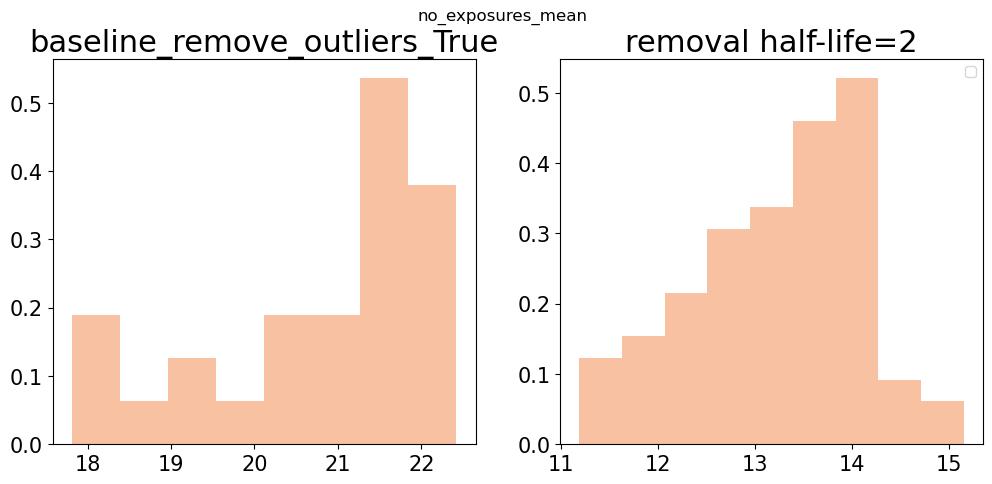

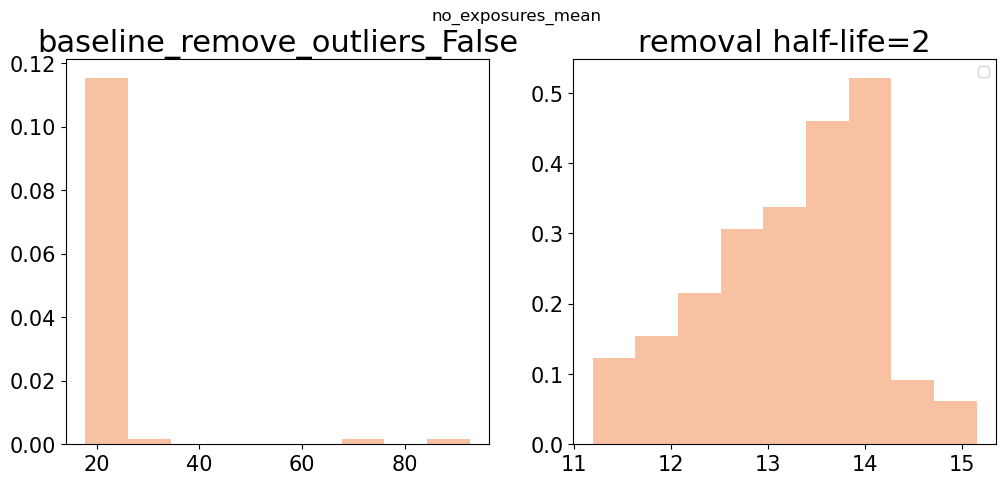

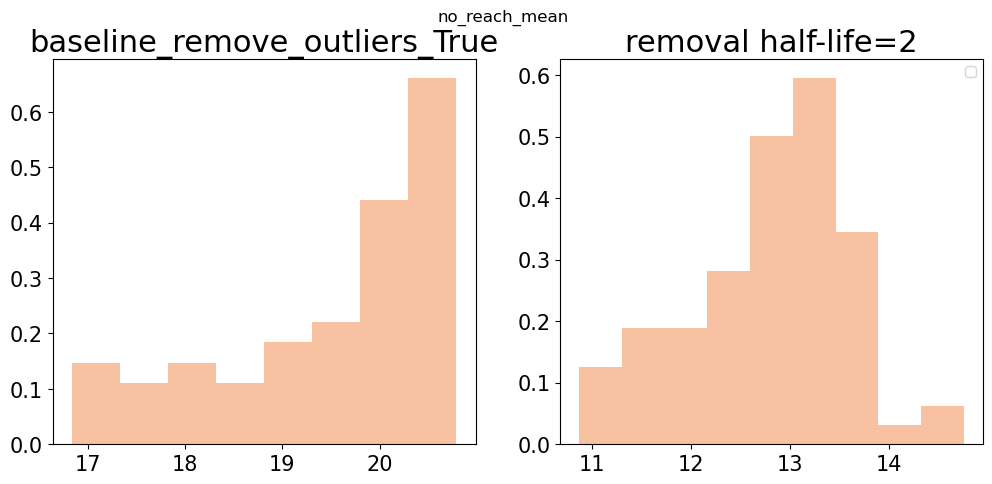

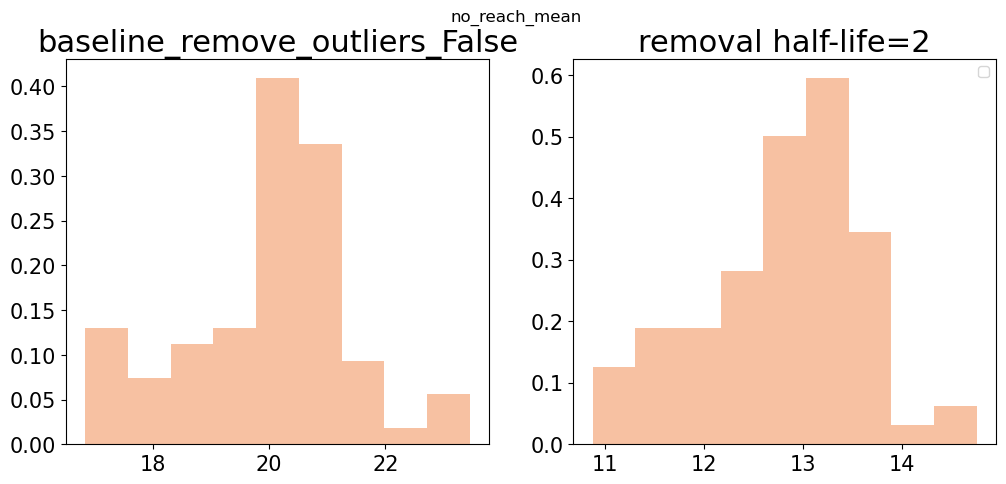

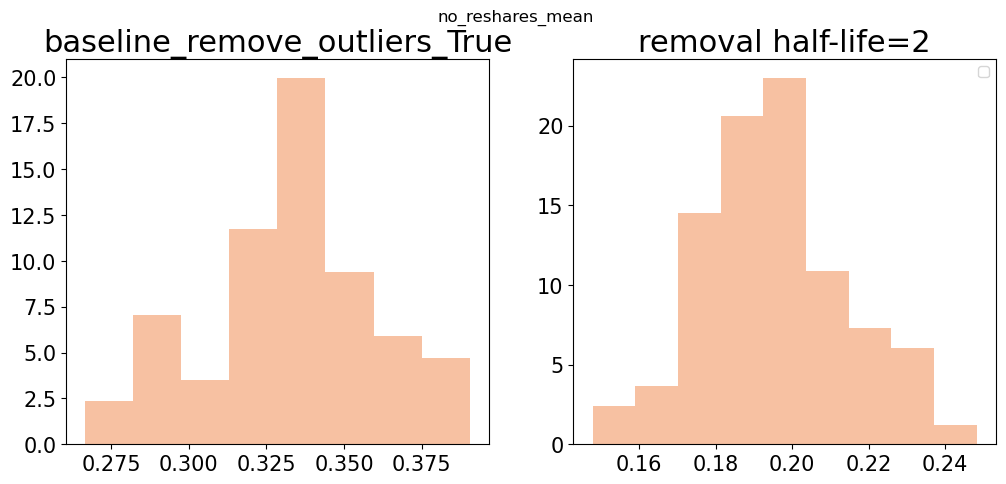

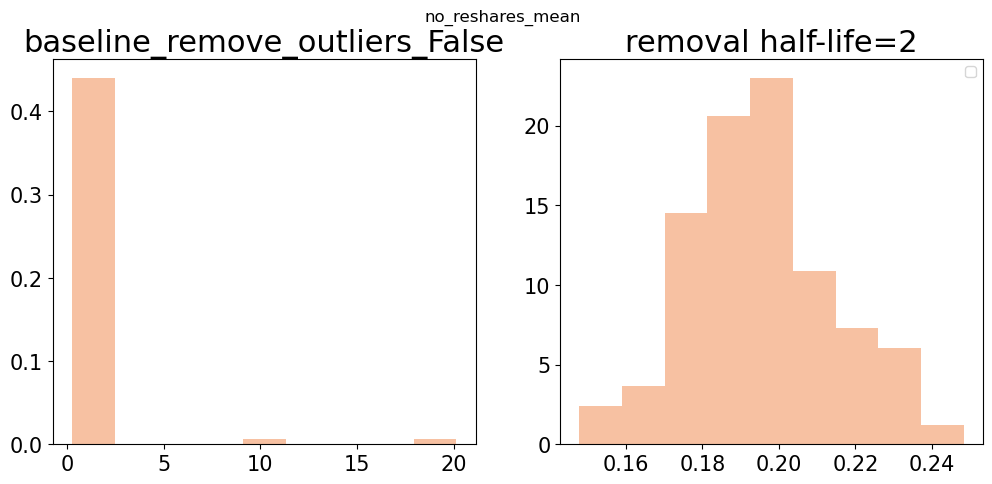

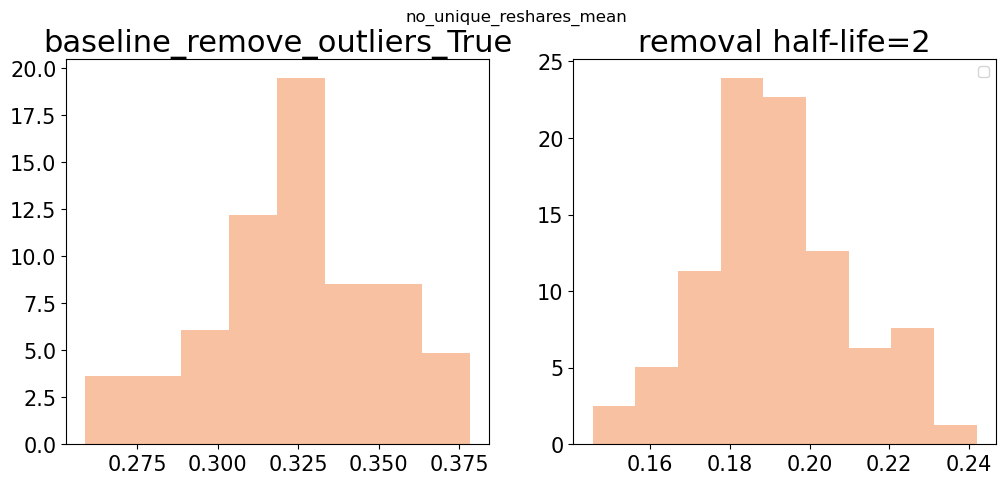

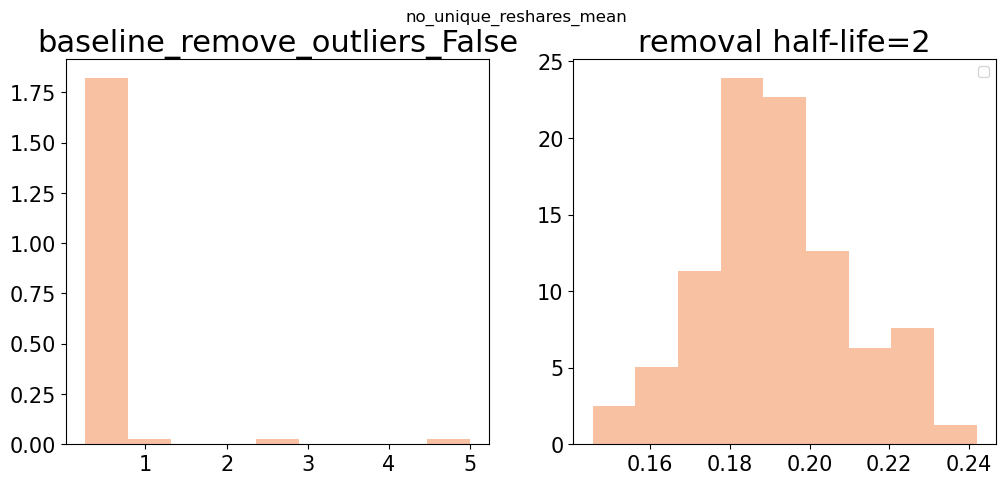

In [26]:
import matplotlib.pyplot as plt

for metric in [
    "no_exposures_mean",
    "no_reach_mean",
    "no_reshares_mean",
    "no_unique_reshares_mean",
]:
    for remove_outlier in [True, False]:
        halflife = 2

        fig, axs = plt.subplots(1, 2, figsize=(12, 5))
        baseline = df[(df.half_life == -1) & (df.type == "illegal")][metric]
        print("Describe baseline:", baseline.describe())
        if remove_outlier:
            baseline = baseline[baseline <= baseline.quantile(0.75)]
            print("Removed outliers:", baseline.describe())
        res = df[(df.half_life != -1) & (df.type == "illegal")]
        axs[0].hist(baseline, bins="rice", density=True, alpha=0.5)
        axs[0].set_title(f"baseline_remove_outliers_{remove_outlier}")
        axs[1].hist(
            res[res.half_life == 2][metric], bins="rice", density=True, alpha=0.5
        )
        axs[1].set_title("removal half-life=2")
        fig.suptitle(f"{metric}")
        plt.legend()

        plt.savefig(f"eda/{metric}_remove_outliers_{remove_outlier}.png")

## Plotting helper

In [27]:
# Function to convert days to the nearest unit, round to 0 decimal places
def convert_days_to_nearest_unit(days, sep=""):

    if days <= 1.5 / 24:  # if around 90 minutes
        return f"{days * 24 * 60:.0f} {sep}minutes"
    elif days <= 1:
        return f"{days * 24:.0f} {sep}hours"
    else:
        return f"{days:.0f}{sep}d"

# Make exposure plot data

In [28]:
from scipy import stats
from tqdm import tqdm
import numpy as np


def make_plot_data(df, focal_metric="no_reshares", random_state=0):
    """
    agg_type: mean or total
    metrics could be {no_unique_reshares_mean, no_unique_reshares_total}
    Aggregation step to get the mean and std of the metrics for each delay value across runs
    """
    ## BASELINE
    # Agg baseline results: For each delay value, the baseline is engagement of normal messages
    print("Filter baseline results...")
    # keep only information columns in metric of interest
    retain_cols = [i for i in df.columns if ("no" not in i) or (focal_metric in i)]
    baseline = df[(df.half_life == -1) & (df.type == "illegal")][focal_metric]

    # NON-BASELINE
    print("Filter treatment results...")
    res = df[(df.half_life != -1) & (df.type == "illegal")][retain_cols]

    raw_bootstrap = []
    bootstrap_res = []

    for half_life in res.half_life.unique():
        print(f"Processing half_life: {half_life}")
        half_life_group = res[res.half_life == half_life]
        # make sure 2 groups have the same number of records
        no_records = min(
            half_life_group.shape[0], baseline.shape[0]
        )  # uncomment if using all records
        baseline_vals = baseline[:no_records]
        removal = half_life_group[:no_records][focal_metric]
        # no_records = 50
        # baseline_vals = baseline.sample(
        #     n=no_records, replace=False, random_state=random_state
        # )
        # removal = half_life_group.sample(
        #     n=no_records, replace=False, random_state=random_state
        # )[focal_metric]
        # create bootstrap sample of pair of observations
        pct_changes = []
        for i in tqdm(range(100), desc=f"Bootstrap half_life={half_life}"):

            bs_removal = removal.sample(
                n=no_records, replace=True, random_state=random_state
            )
            bs_baseline = baseline_vals.sample(
                n=no_records, replace=True, random_state=random_state
            )
            pct_change = get_pct_change(bs_baseline, bs_removal)
            record = {
                "bs_removal": bs_removal,
                "bs_baseline": bs_baseline,
                "pct_changes": pct_changes,
                "half_life": half_life,
            }
            raw_bootstrap.append(record)
            pct_changes.append(pct_change)
        print("Calculate bootstrap statistics...")
        pct_changes = np.array(pct_changes)
        mu, sigma = np.mean(pct_changes), pct_changes.std(ddof=1)
        N = len(pct_changes)
        std = np.std(pct_changes)
        ci = stats.norm.interval(0.95, loc=mu, scale=sigma / np.sqrt(N))
        print(f"Mean: {mu}, Std: {std}, CI: {ci}")
        bootstrap_res.append(
            {
                "half_life": half_life,
                "pct_mean": mu,
                "std": std,
                "lower": ci[0],
                "upper": ci[1],
            }
        )
        bootstrap_df = pd.DataFrame(bootstrap_res).sort_values(by="half_life")
    return bootstrap_df

# All exposure metrics

In [29]:
# focal = make_plot_data(df, focal_metric="no_reshares_mean")

# Setting & Get plotting data for all metrics 

In [30]:
metrics = [
    ("no_reshares", "mean"),
    ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
    ("no_reach", "mean"),
]
exposure_data = dict()
for focal_metric, agg_type in metrics:
    focal_metric_agg = f"{focal_metric}_{agg_type}"

    focal_data = make_plot_data(df, focal_metric=focal_metric_agg, random_state=30)
    focal_data["mean_lifetime"] = focal_data[x_col] / np.log(2)
    focal_data["human_vals"] = focal_data["mean_lifetime"].apply(
        lambda x: convert_days_to_nearest_unit(x, sep="\n")
    )
    exposure_data[focal_metric_agg] = focal_data

Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1596.13it/s]


Calculate bootstrap statistics...
Mean: -0.9830639467432782, Std: 0.0018314710070090944, CI: (-0.9834229443660824, -0.9827049491204741)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1630.52it/s]


Calculate bootstrap statistics...
Mean: -0.5128306483519471, Std: 0.2027096155937097, CI: (-0.5525638411268757, -0.4730974555770185)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1648.43it/s]


Calculate bootstrap statistics...
Mean: -0.8421716585562238, Std: 0.016248495994941395, CI: (-0.8453565234004254, -0.8389867937120221)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1579.45it/s]


Calculate bootstrap statistics...
Mean: -0.573581860561673, Std: 0.08619753682248524, CI: (-0.5904774742071369, -0.5566862469162092)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1651.69it/s]


Calculate bootstrap statistics...
Mean: -0.044839479434629605, Std: 3.040539548284144, CI: (-0.6408168515880461, 0.5511378927187869)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1672.76it/s]


Calculate bootstrap statistics...
Mean: 0.19513491920872406, Std: 3.7768347666114424, CI: (-0.5451639729839447, 0.9354338114013928)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1676.49it/s]


Calculate bootstrap statistics...
Mean: -0.15017086949158454, Std: 1.8911311437416738, CI: (-0.5208522408556515, 0.2205105018724825)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1642.11it/s]


Calculate bootstrap statistics...
Mean: -0.6555784880441133, Std: 0.1173306612416055, CI: (-0.6785765178507823, -0.6325804582374444)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1662.95it/s]


Calculate bootstrap statistics...
Mean: -0.7503400460852229, Std: 0.026314088658546106, CI: (-0.7554978659783317, -0.745182226192114)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1658.29it/s]


Calculate bootstrap statistics...
Mean: 0.24287972727413737, Std: 2.011510837241935, CI: (-0.15139731592830658, 0.6371567704765813)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1672.82it/s]


Calculate bootstrap statistics...
Mean: -0.6079415504337421, Std: 0.08758865087704981, CI: (-0.6251098196267054, -0.5907732812407788)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1674.91it/s]


Calculate bootstrap statistics...
Mean: -0.9200673181438744, Std: 0.012600453348925546, CI: (-0.9225371821525694, -0.9175974541351795)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1650.01it/s]


Calculate bootstrap statistics...
Mean: -0.9998997006655347, Std: 0.00017720920931737585, CI: (-0.9999344365060915, -0.9998649648249779)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1652.35it/s]


Calculate bootstrap statistics...
Mean: -0.9987605600052508, Std: 0.00037538434262857366, CI: (-0.9988341407977939, -0.9986869792127078)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 650.51it/s]


Calculate bootstrap statistics...
Mean: -0.9703450311101296, Std: 0.003340665319822917, CI: (-0.9709998549669152, -0.969690207253344)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1645.24it/s]


Calculate bootstrap statistics...
Mean: -0.20048785109218223, Std: 0.2532905198346011, CI: (-0.25013542712439873, -0.1508402750599657)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1649.53it/s]


Calculate bootstrap statistics...
Mean: -0.7285573763949297, Std: 0.02751657483496063, CI: (-0.7339508953921337, -0.7231638573977257)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1644.74it/s]


Calculate bootstrap statistics...
Mean: -0.2793391557458166, Std: 0.11412535220845738, CI: (-0.30170891164774616, -0.256969399843887)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1662.05it/s]


Calculate bootstrap statistics...
Mean: -0.007410830855060551, Std: 0.9709235940688163, CI: (-0.19772195260364298, 0.18290029089352186)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1669.53it/s]


Calculate bootstrap statistics...
Mean: 0.1353934796410963, Std: 2.065198331037043, CI: (-0.26940687067885183, 0.5401938299610445)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1660.37it/s]


Calculate bootstrap statistics...
Mean: -0.06042070409118887, Std: 0.6118442911204443, CI: (-0.18034854814597553, 0.0595071399635978)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1682.68it/s]


Calculate bootstrap statistics...
Mean: -0.4219830967880802, Std: 0.12901062420708623, CI: (-0.44727052080405816, -0.39669567277210227)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1514.75it/s]


Calculate bootstrap statistics...
Mean: -0.5717273275312204, Std: 0.04513216088369379, CI: (-0.5805736744537957, -0.562880980608645)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1644.96it/s]


Calculate bootstrap statistics...
Mean: 0.1786406915952145, Std: 0.8903350244753829, CI: (0.004125767583642664, 0.3531556156067863)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1649.61it/s]


Calculate bootstrap statistics...
Mean: -0.3307259589151829, Std: 0.13586572903172356, CI: (-0.35735702797216773, -0.3040948898581981)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1668.67it/s]


Calculate bootstrap statistics...
Mean: -0.8668013596606597, Std: 0.01958956887329289, CI: (-0.8706411874641669, -0.8629615318571526)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1668.15it/s]


Calculate bootstrap statistics...
Mean: -0.9998225185660893, Std: 0.0003135748082429007, CI: (-0.9998839842460261, -0.9997610528861525)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1648.52it/s]


Calculate bootstrap statistics...
Mean: -0.9978976696793853, Std: 0.000625251371329014, CI: (-0.9980202280448165, -0.9977751113139541)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1670.45it/s]


Calculate bootstrap statistics...
Mean: -0.9548028692697229, Std: 0.0039581609179953035, CI: (-0.9555787321443185, -0.9540270063951273)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1688.37it/s]


Calculate bootstrap statistics...
Mean: -0.1131499742285209, Std: 0.0927284285411324, CI: (-0.13132571057013398, -0.09497423788690781)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1623.42it/s]


Calculate bootstrap statistics...
Mean: -0.6165038745815714, Std: 0.023978121983210275, CI: (-0.6212038220572074, -0.6118039271059355)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1669.82it/s]


Calculate bootstrap statistics...
Mean: -0.145711082143676, Std: 0.06449468404975886, CI: (-0.15835271094259473, -0.13306945334475728)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 695.28it/s]


Calculate bootstrap statistics...
Mean: -0.022716375950273662, Std: 0.421202758230385, CI: (-0.10527649694444949, 0.05984374504390216)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1672.83it/s]


Calculate bootstrap statistics...
Mean: 0.03822860964889189, Std: 0.6279883935379612, CI: (-0.0848636463735, 0.1613208656712838)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1680.65it/s]


Calculate bootstrap statistics...
Mean: -0.0191594572213141, Std: 0.33524624489910343, CI: (-0.08487120768087324, 0.04655229323824504)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1663.96it/s]


Calculate bootstrap statistics...
Mean: -0.29200746832944247, Std: 0.05234876143570799, CI: (-0.30226836998209344, -0.2817465666767915)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 1679.42it/s]


Calculate bootstrap statistics...
Mean: -0.4282583687626775, Std: 0.04091616333785379, CI: (-0.43627833874727867, -0.4202383987780763)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1658.85it/s]


Calculate bootstrap statistics...
Mean: 0.047692800268527555, Std: 0.33757467978980465, CI: (-0.018475347644626147, 0.11386094818168126)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1622.99it/s]


Calculate bootstrap statistics...
Mean: -0.19206360192064859, Std: 0.06217709274676579, CI: (-0.20425094645927794, -0.17987625738201923)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1673.74it/s]


Calculate bootstrap statistics...
Mean: -0.819986864507117, Std: 0.01683871638709336, CI: (-0.8232874869851686, -0.8166862420290654)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1668.45it/s]


Calculate bootstrap statistics...
Mean: -0.9999580859950346, Std: 0.0001216124465651927, CI: (-0.9999819239804862, -0.9999342480095829)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1655.44it/s]


Calculate bootstrap statistics...
Mean: -0.997374096595824, Std: 0.0007865418769030909, CI: (-0.9975282702469292, -0.9972199229447187)
Filter baseline results...
Filter treatment results...
Processing half_life: 0.25


Bootstrap half_life=0.25: 100%|██████████| 100/100 [00:00<00:00, 1686.57it/s]


Calculate bootstrap statistics...
Mean: -0.9487042032053269, Std: 0.0045003289189166915, CI: (-0.9495863396833519, -0.9478220667273018)
Processing half_life: 32.0


Bootstrap half_life=32.0: 100%|██████████| 100/100 [00:00<00:00, 1668.75it/s]


Calculate bootstrap statistics...
Mean: -0.04655872459338122, Std: 0.07282185507564068, CI: (-0.06083256551342751, -0.03228488367333494)
Processing half_life: 1.0


Bootstrap half_life=1.0: 100%|██████████| 100/100 [00:00<00:00, 1655.64it/s]


Calculate bootstrap statistics...
Mean: -0.5678480973373762, Std: 0.02668966742640115, CI: (-0.5730795343587621, -0.5626166603159902)
Processing half_life: 16.0


Bootstrap half_life=16.0: 100%|██████████| 100/100 [00:00<00:00, 1648.94it/s]


Calculate bootstrap statistics...
Mean: -0.06946542233613033, Std: 0.06784597462399847, CI: (-0.08276393894000622, -0.05616690573225444)
Processing half_life: 64.0


Bootstrap half_life=64.0: 100%|██████████| 100/100 [00:00<00:00, 1674.06it/s]


Calculate bootstrap statistics...
Mean: -0.02052024160479066, Std: 0.0724504584507486, CI: (-0.034721284923945765, -0.006319198285635553)
Processing half_life: 512.0


Bootstrap half_life=512.0: 100%|██████████| 100/100 [00:00<00:00, 1639.29it/s]


Calculate bootstrap statistics...
Mean: 0.0011181553595445088, Std: 0.09869898608464912, CI: (-0.018227872352586647, 0.020464183071675662)
Processing half_life: 256.0


Bootstrap half_life=256.0: 100%|██████████| 100/100 [00:00<00:00, 1657.26it/s]


Calculate bootstrap statistics...
Mean: -0.009940164719773551, Std: 0.0683677205998578, CI: (-0.02334094896091788, 0.0034606195213707763)
Processing half_life: 4.0


Bootstrap half_life=4.0: 100%|██████████| 100/100 [00:00<00:00, 1679.42it/s]


Calculate bootstrap statistics...
Mean: -0.21873861333692682, Std: 0.05981085558150205, CI: (-0.2304621630456708, -0.20701506362818284)
Processing half_life: 2.0


Bootstrap half_life=2.0: 100%|██████████| 100/100 [00:00<00:00, 673.05it/s]


Calculate bootstrap statistics...
Mean: -0.3631272483665804, Std: 0.04509056917146579, CI: (-0.371965442904952, -0.3542890538282088)
Processing half_life: 128.0


Bootstrap half_life=128.0: 100%|██████████| 100/100 [00:00<00:00, 1668.60it/s]


Calculate bootstrap statistics...
Mean: -0.00137245873607711, Std: 0.0663719712920594, CI: (-0.014382055357705056, 0.011637137885550835)
Processing half_life: 8.0


Bootstrap half_life=8.0: 100%|██████████| 100/100 [00:00<00:00, 1659.67it/s]


Calculate bootstrap statistics...
Mean: -0.11632446841695057, Std: 0.06398927679743192, CI: (-0.12886701951827378, -0.10378191731562736)
Processing half_life: 0.5


Bootstrap half_life=0.5: 100%|██████████| 100/100 [00:00<00:00, 1551.37it/s]


Calculate bootstrap statistics...
Mean: -0.7993005171972631, Std: 0.018784965385842713, CI: (-0.8029826315328581, -0.7956184028616682)
Processing half_life: 0.0625


Bootstrap half_life=0.0625: 100%|██████████| 100/100 [00:00<00:00, 1675.76it/s]


Calculate bootstrap statistics...
Mean: -0.9999523186588646, Std: 0.00013834622951867356, CI: (-0.999979436733533, -0.9999252005841962)
Processing half_life: 0.125


Bootstrap half_life=0.125: 100%|██████████| 100/100 [00:00<00:00, 1664.00it/s]


Calculate bootstrap statistics...
Mean: -0.9970379075348931, Std: 0.0008873208871745211, CI: (-0.9972118353382242, -0.9968639797315619)


# Plot combine

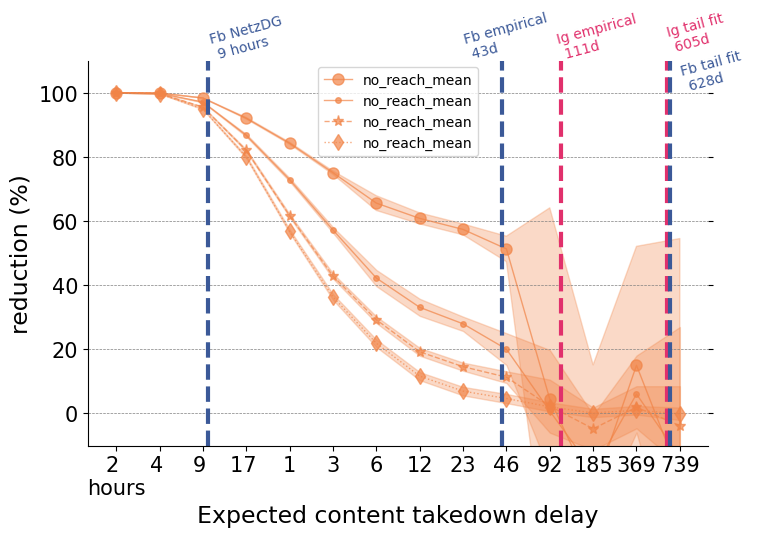

In [31]:
import matplotlib.pyplot as plt

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"combine__logx")

x_col = "half_life"
y_label = f"reduction (%)"
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, ax = plt.subplots(figsize=(8, 5))  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
### GET DATA

# Define the focal metrics and aggregation types

markers = ["o", ".", "*", "d"]
lines = ["-", "-", "--", ":"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
        # x_tickvalues = x
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[0],
        linewidth=1,
        linestyle=lines[idx],
        label=focal_metric_agg,
        alpha=0.7,
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[0],
        alpha=0.3,
    )
    idx += 1

plt.legend()
# Plot dashed lines at specified values with alternating colors
x_values = [0.27, 29.62, 77, 419.35, 435.14]
meanlife_values = x_values / np.log(2)
human_meanlife_values = [convert_days_to_nearest_unit(val) for val in meanlife_values]
country = ["Fb NetzDG", "Fb empirical", "Ig empirical", "Ig tail fit", "Fb tail fit"]
labels = [f"{c} \n {h}" for c, h in zip(country, human_meanlife_values)]
# Offset values for overlapping labels
x_offsets = [0, -20, -10, -20, 100]  # Adjust these values as needed
y_offsets = [0, 0, 0, 2, -10]  # Adjust these values as needed

for idx, (x_val, label, x_offset, y_offset) in enumerate(
    zip(meanlife_values, labels, x_offsets, y_offsets)
):
    if "Fb" in label:
        color = "#3b5998"
    if "Ig" in label:
        color = "#E1306C"  # purple red
    ax.axvline(x=x_val, color=color, linestyle="--", label=label)
    ax.text(
        x_val + x_offset,
        ax.get_ylim()[1] + y_offset,
        label,
        rotation=15,
        verticalalignment="bottom",
        fontsize=10,
        color=color,
    )

# Additional plot settings
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

custom_xticks = x
# if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
custom_xtick_labels = []
first_hour = False
first_day = False
for idx, xtick in enumerate(xticks):
    if "hours" in xtick and not first_hour:
        custom_xtick_labels.append(xtick)
        first_hour = True
    elif "days" in xtick and not first_day:
        custom_xtick_labels.append(xtick)
        first_day = True
    else:
        custom_xtick_labels.append(xtick.split("\n")[0])


from matplotlib.ticker import FixedLocator, FuncFormatter

ax.set_xscale("log", base=2)
ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
)

ax.tick_params(
    labelleft=True,
    labelright=False,
    left=True,
    right=True,
)
## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
ax.set_ylim(-10, 110)
# Hide spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")
# plt.tight_layout()

# plt.savefig(f"{fpath}.png", dpi=300)
# plt.show()

# Exposure and prevalence (no annot)

Drawing line Prevalence
X: (0.13008556131285048, 0.26017112262570097, 0.5203422452514019, 1.0406844905028039, 2.0813689810056077, 4.1627379620112155, 8.325475924022431, 16.650951848044862, 33.301903696089724, 66.60380739217945, 133.2076147843589, 266.4152295687178, 532.8304591374356, 1065.6609182748712)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.985

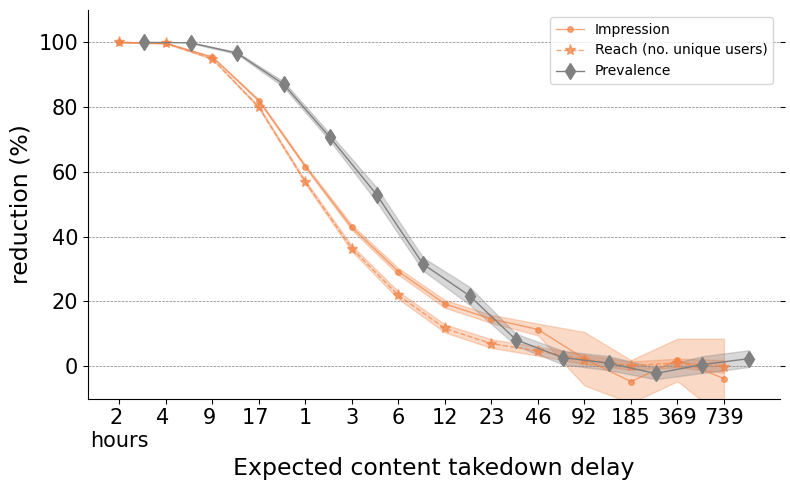

In [32]:
import matplotlib.pyplot as plt

plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"combine_with_prevalence")

x_col = "half_life"
y_label = f"reduction (%)"
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, ax = plt.subplots(figsize=(8, 5))  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
### GET DATA

# Define the focal metrics and aggregation types
metrics = [
    ("no_exposures", "mean"),
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
]
labels = [
    "Impression",
    "Reach (no. unique users)",
    #   "Reshare"
]
markers = [".", "*", "d"]
lines = ["-", "--", ":"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
        # x_tickvalues = x
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[0],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[0],
        alpha=0.3,
    )
    idx += 1


# READ PLOT DATA FOR PREVALENCE
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(np.array(prevalence_plot_data["x"]) / np.log(2)) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    ax,
    plot_data_prevalence,
    line_name="Prevalence",
    marker="d",
    color="grey",
    absolute=True,
)

plt.legend()

# Additional plot settings
ax.set_xlabel(x_label)
ax.set_ylabel(y_label)

custom_xticks = x
# if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
custom_xtick_labels = []
first_hour = False
first_day = False
for idx, xtick in enumerate(xticks):
    if "hours" in xtick and not first_hour:
        custom_xtick_labels.append(xtick)
        first_hour = True
    elif "days" in xtick and not first_day:
        custom_xtick_labels.append(xtick)
        first_day = True
    else:
        custom_xtick_labels.append(xtick.split("\n")[0])


from matplotlib.ticker import FixedLocator, FuncFormatter

ax.set_xscale("log", base=2)
ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
ax.xaxis.set_major_formatter(
    FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
)

ax.tick_params(
    labelleft=True,
    labelright=False,
    left=True,
    right=True,
)
## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
ax.set_ylim(-10, 110)
# Hide spines
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
plt.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")
plt.tight_layout()

plt.savefig(f"{fpath}.png", dpi=300)
plt.show()

# 2 panels

Drawing line Prevalence
X: (0.09016844005556021, 0.18033688011112042, 0.36067376022224085, 0.7213475204444817, 1.4426950408889634, 2.8853900817779268, 5.7707801635558535, 11.541560327111707, 23.083120654223414, 46.16624130844683, 92.33248261689366, 184.6649652337873, 369.3299304675746, 738.6598609351493)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98

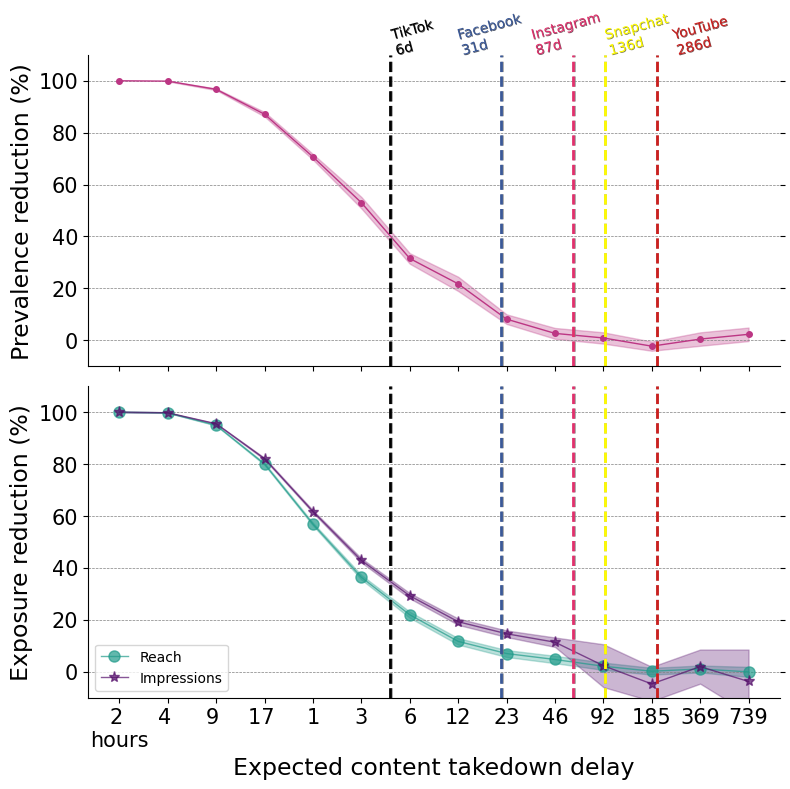

In [42]:
import matplotlib.pyplot as plt

PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"main_res_dsa1year")

x_col = "half_life"
y_labels = ["Prevalence reduction (%)", "Exposure reduction (%)"]
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, axs = plt.subplots(
    2, 1, figsize=(8, 8), sharex=True, sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# PLOT PREVALENCE
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(prevalence_plot_data["x"]) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    axs[0],
    plot_data_prevalence,
    line_name="Prevalence",
    marker=".",
    color=PALETTE[-1],
    absolute=True,
)

## PLOT EXPOSURE
ax = axs[1]
# Define the focal metrics and aggregation types
metrics = [
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
]
labels = [
    "Reach",
    #   "Engagement",
    "Impressions",
]
markers = ["o", "*", "d"]
lines = ["-", "-", "--"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
    if labels[idx] == "Impression":
        ax = axs[1]
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[idx],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[idx],
        alpha=0.3,
    )
    idx += 1

    ax.legend(loc="lower left")


# Additional plot settings
from matplotlib.ticker import FixedLocator, FuncFormatter

for kdx, ax in enumerate(axs):
    # Plot dashed lines at specified values with alternating colors
    half_lives = {
        "TikTok": 4.330755832477102,
        "Facebook": 21.169685437132635,
        "Instagram": 60.17239205413954,
        "Snapchat": 94.12900430900339,
        "YouTube": 198.41224859619473,
    }
    colors = {
        "Snapchat": "#fffc00",
        "Facebook": "#3b5998",
        "Instagram": "#E1306C",
        "YouTube": "#CD201F",
        "TikTok": "#000000",
    }

    # Offset values for overlapping labels
    # x ,y offset
    offsets = [(0, 3), (-10, 3), (-28, 3), (-2, 3), (45, 3)]
    # offsets = [(0, 0), (-35, 3), (-55, 3), (-20, 3), (-5, 3)]

    for jdx, platform in enumerate(half_lives.keys()):
        meanlife_value = half_lives[platform] / np.log(2)
        human_meanlife_value = convert_days_to_nearest_unit(meanlife_value)
        x_offset, y_offset = offsets[jdx]
        label = f"{platform} \n{human_meanlife_value}"
        # plot shadow
        shadow_offset=0.1 + jdx * 0.2

        ax.axvline(
        x=half_lives[platform] + shadow_offset,
        color="gray",
        linestyle="--",
        linewidth=2,
        alpha=0.7,
    )
        ax.axvline(
            x=half_lives[platform],
            color=colors[platform],
            linestyle="--",
            label=label,
            linewidth=2,
        )
        
        if kdx == 0:
            text = ax.text(
                # half_lives[platform],
                # ax.get_ylim()[1],
                half_lives[platform] + x_offset,
                ax.get_ylim()[1] + y_offset,
                label,
                rotation=15,
                verticalalignment="bottom",
                fontsize=10,
                color=colors[platform],
            )
            import matplotlib.patheffects as path_effects

            # Add a shadow effect
            text.set_path_effects(
                [path_effects.withSimplePatchShadow(offset=(0.5, -0.5), alpha=0.7)]
            )

    ax.set_xscale("log", base=2)
    ax.set_ylabel(y_labels[kdx])

    if kdx == 1:
        # Setting for exposure plot
        ax.set_xlabel(x_label)

        custom_xticks = x
        # if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
        custom_xtick_labels = []
        first_hour = False
        first_day = False
        for idx, xtick in enumerate(xticks):
            if "hours" in xtick and not first_hour:
                custom_xtick_labels.append(xtick)
                first_hour = True
            elif "days" in xtick and not first_day:
                custom_xtick_labels.append(xtick)
                first_day = True
            else:
                custom_xtick_labels.append(xtick.split("\n")[0])

        ## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
        ax.set_ylim(-10, 110)

    ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
    )
    if kdx == 0:
        ax.set_xticklabels([])
    ax.tick_params(
        labelleft=True,
        labelright=False,
        left=True,
        right=True,
    )

    # Hide spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")
plt.tight_layout()

plt.savefig(f"{fpath}.png", dpi=300)
plt.savefig(f"{fpath}.pdf", dpi=300)
plt.show()

# No annotation plot

Drawing line Prevalence
X: (0.09016844005556021, 0.18033688011112042, 0.36067376022224085, 0.7213475204444817, 1.4426950408889634, 2.8853900817779268, 5.7707801635558535, 11.541560327111707, 23.083120654223414, 46.16624130844683, 92.33248261689366, 184.6649652337873, 369.3299304675746, 738.6598609351493)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98

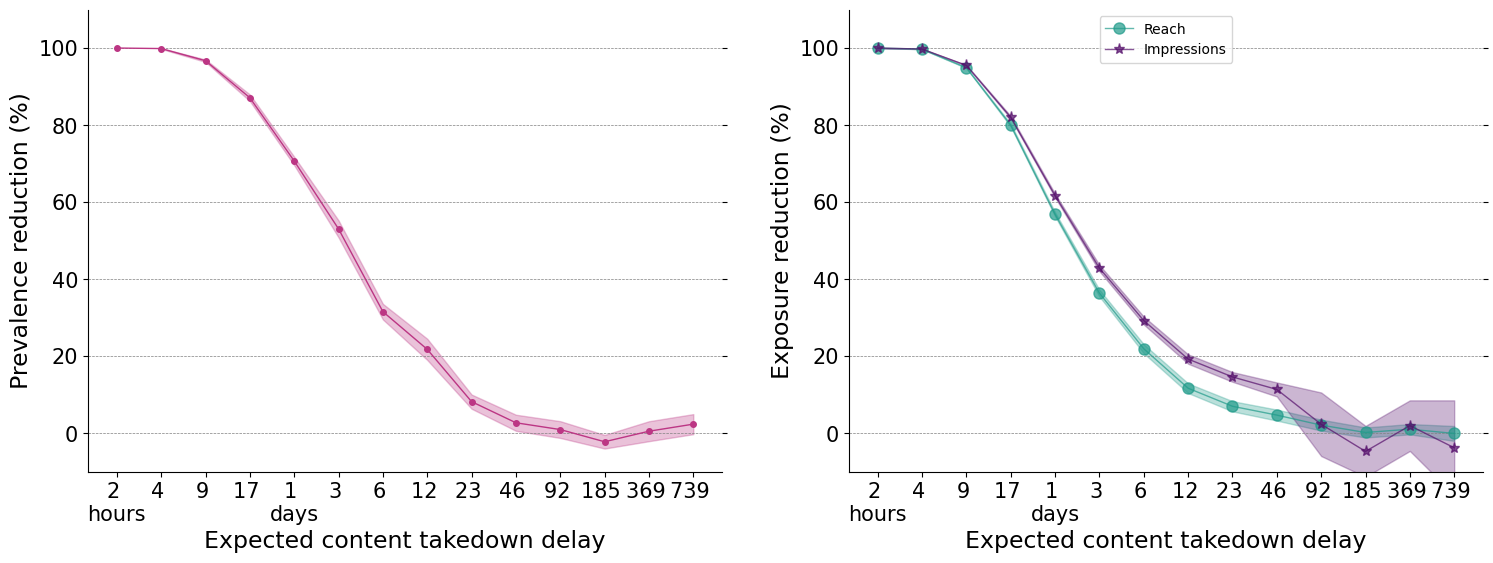

In [ ]:
import matplotlib.pyplot as plt
import pickle as pkl

PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"main_res_palette4_noannot")

x_col = "half_life"
y_labels = ["Prevalence reduction (%)", "Exposure reduction (%)"]
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharex=True, sharey=True)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# PLOT PREVALENCE
prevalence_plot_data = pkl.load(open(f"{PLOT_DIR}/prevalence_plotdata.pkl", "rb"))
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(prevalence_plot_data["x"]) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    axs[0],
    plot_data_prevalence,
    line_name="Prevalence",
    marker=".",
    color=PALETTE[-1],
    absolute=True,
)

## PLOT EXPOSURE
ax = axs[1]
# Define the focal metrics and aggregation types
metrics = [
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
]
labels = [
    "Reach",
    #   "Engagement",
    "Impressions",
]
markers = ["o", "*", "d"]
lines = ["-", "-", "--"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]
    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
    if labels[idx] == "Impression":
        ax = axs[1]
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[idx],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[idx],
        alpha=0.3,
    )
    idx += 1

    ax.legend(loc="upper center")


# Additional plot settings
from matplotlib.ticker import FixedLocator, FuncFormatter

for kdx, ax in enumerate(axs):

    ax.set_xscale("log", base=2)
    ax.set_ylabel(y_labels[kdx])

    # Setting for exposure plot
    ax.set_xlabel(x_label)

    custom_xticks = x
    # if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
    custom_xtick_labels = []
    first_hour = False
    first_day = False
    for idx, xtick in enumerate(xticks):
        if "hours" in xtick and not first_hour:
            custom_xtick_labels.append(xtick)
            first_hour = True
        elif "days" in xtick and not first_day:
            custom_xtick_labels.append(xtick)
            first_day = True
        else:
            custom_xtick_labels.append(xtick.split("\n")[0])

    ## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
    ax.set_ylim(-10, 110)

    ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
    )
    if kdx == 0:
        ax.set_xticklabels([])
    ax.tick_params(
        labelleft=True,
        labelright=False,
        left=True,
        right=True,
    )

    # Hide spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")

# plt.tight_layout()

# plt.savefig(f"{fpath}.png", dpi=300)
# plt.savefig(f"{fpath}.pdf", dpi=300)
# plt.show()

# White annotation
Annotate in white to have the same size with the annotated plot

Drawing line Prevalence
X: (0.09016844005556021, 0.18033688011112042, 0.36067376022224085, 0.7213475204444817, 1.4426950408889634, 2.8853900817779268, 5.7707801635558535, 11.541560327111707, 23.083120654223414, 46.16624130844683, 92.33248261689366, 184.6649652337873, 369.3299304675746, 738.6598609351493)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98

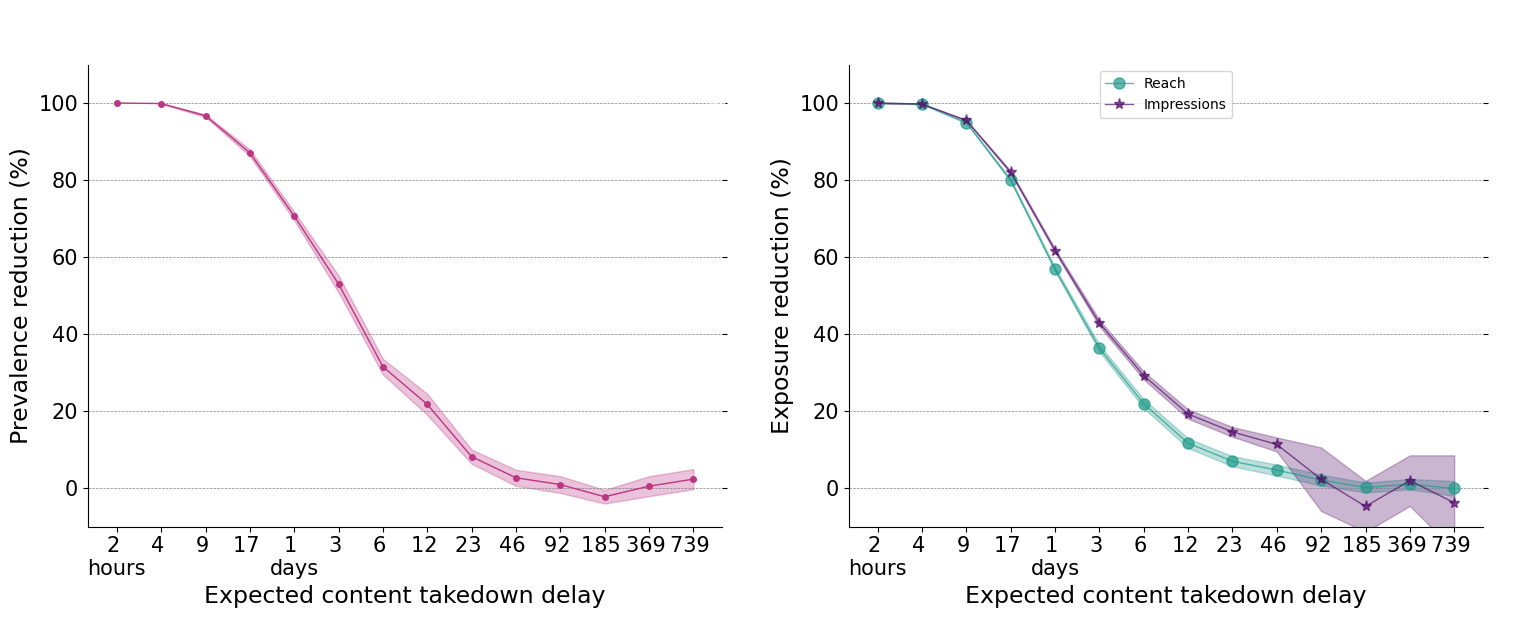

In [ ]:
import matplotlib.pyplot as plt

PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"main_res_palette4_presentation_white_annot")

x_col = "half_life"
y_labels = ["Prevalence reduction (%)", "Exposure reduction (%)"]
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, axs = plt.subplots(
    1, 2, figsize=(18, 6), sharex=True, sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# PLOT PREVALENCE
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(prevalence_plot_data["x"]) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    axs[0],
    plot_data_prevalence,
    line_name="Prevalence",
    marker=".",
    color=PALETTE[-1],
    absolute=True,
)

## PLOT EXPOSURE
ax = axs[1]
# Define the focal metrics and aggregation types
metrics = [
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
]
labels = [
    "Reach",
    #   "Engagement",
    "Impressions",
]
markers = ["o", "*", "d"]
lines = ["-", "-", "--"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
    if labels[idx] == "Impression":
        ax = axs[1]
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[idx],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[idx],
        alpha=0.3,
    )
    idx += 1

    ax.legend(loc="upper center")


# Additional plot settings
from matplotlib.ticker import FixedLocator, FuncFormatter

for kdx, ax in enumerate(axs):
    # Plot dashed lines at specified values with alternating colors
    x_values = [0.27, 29.62, 77, 419.35, 435.14]
    meanlife_values = x_values / np.log(2)
    human_meanlife_values = [
        convert_days_to_nearest_unit(val) for val in meanlife_values
    ]
    country = [
        "Fb NetzDG",
        "Fb empirical",
        "Ig empirical",
        "Ig tail fit",
        "Fb tail fit",
    ]
    labels = [f"{c} \n {h}" for c, h in zip(country, human_meanlife_values)]
    # Offset values for overlapping labels
    x_offsets = [0, -20, -10, -20, 100]  # Adjust these values as needed
    y_offsets = [0, 0, 0, 2, -10]  # Adjust these values as needed

    for jdx, (x_val, label, x_offset, y_offset) in enumerate(
        zip(meanlife_values, labels, x_offsets, y_offsets)
    ):
        # ax.axvline(x=x_val, color="white", linestyle="--", label=label, linewidth=2)
        # if kdx == 0:
        ax.text(
            x_val + x_offset,
            ax.get_ylim()[1] + y_offset,
            label,
            rotation=15,
            verticalalignment="bottom",
            fontsize=10,
            color="white",
        )

    ax.set_xscale("log", base=2)
    ax.set_ylabel(y_labels[kdx])

    # XLABEL & TICKS FOR BOTH PLOTS
    # Setting for exposure plot
    ax.set_xlabel(x_label)

    custom_xticks = x
    # if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
    custom_xtick_labels = []
    first_hour = False
    first_day = False
    for idx, xtick in enumerate(xticks):
        if "hours" in xtick and not first_hour:
            custom_xtick_labels.append(xtick)
            first_hour = True
        elif "days" in xtick and not first_day:
            custom_xtick_labels.append(xtick)
            first_day = True
        else:
            custom_xtick_labels.append(xtick.split("\n")[0])

    ## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
    ax.set_ylim(-10, 110)

    ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
    )
    # if kdx == 0:
    #     ax.set_xticklabels([])
    ax.tick_params(
        labelleft=True,
        labelright=False,
        left=True,
        right=True,
    )

    # Hide spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")

# plt.tight_layout()

# plt.savefig(f"{fpath}.png", dpi=300, bbox_inches="tight")
# # plt.savefig(f"{fpath}.pdf", dpi=300)
# plt.show()

# Annotation for presentation

Drawing line Prevalence
X: (0.09016844005556021, 0.18033688011112042, 0.36067376022224085, 0.7213475204444817, 1.4426950408889634, 2.8853900817779268, 5.7707801635558535, 11.541560327111707, 23.083120654223414, 46.16624130844683, 92.33248261689366, 184.6649652337873, 369.3299304675746, 738.6598609351493)
Y: (-100.0, -99.86036439059343, -96.70048034506668, -87.07582055592286, -70.65514652019152, -53.00883507191758, -31.518527505947127, -21.735210072938344, -8.149330267687096, -2.662384811985556, -0.8996742572606304, 2.268056860121284, -0.46999755503313084, -2.3061637398767876)
Y lower: (nan, -99.95713411961536, -97.01053213833742, -87.93642838454616, -71.74989649566503, -55.2189208562149, -33.54599659679529, -24.48530178084467, -9.991048217350404, -4.750829713148651, -3.0760553464684626, 0.4995991164134579, -3.0597251899521902, -4.908977116913676)
Y upper: (nan, -99.76359466157149, -96.39042855179592, -86.21521272729954, -69.56039654471802, -50.79874928762026, -29.49105841509896, -18.98

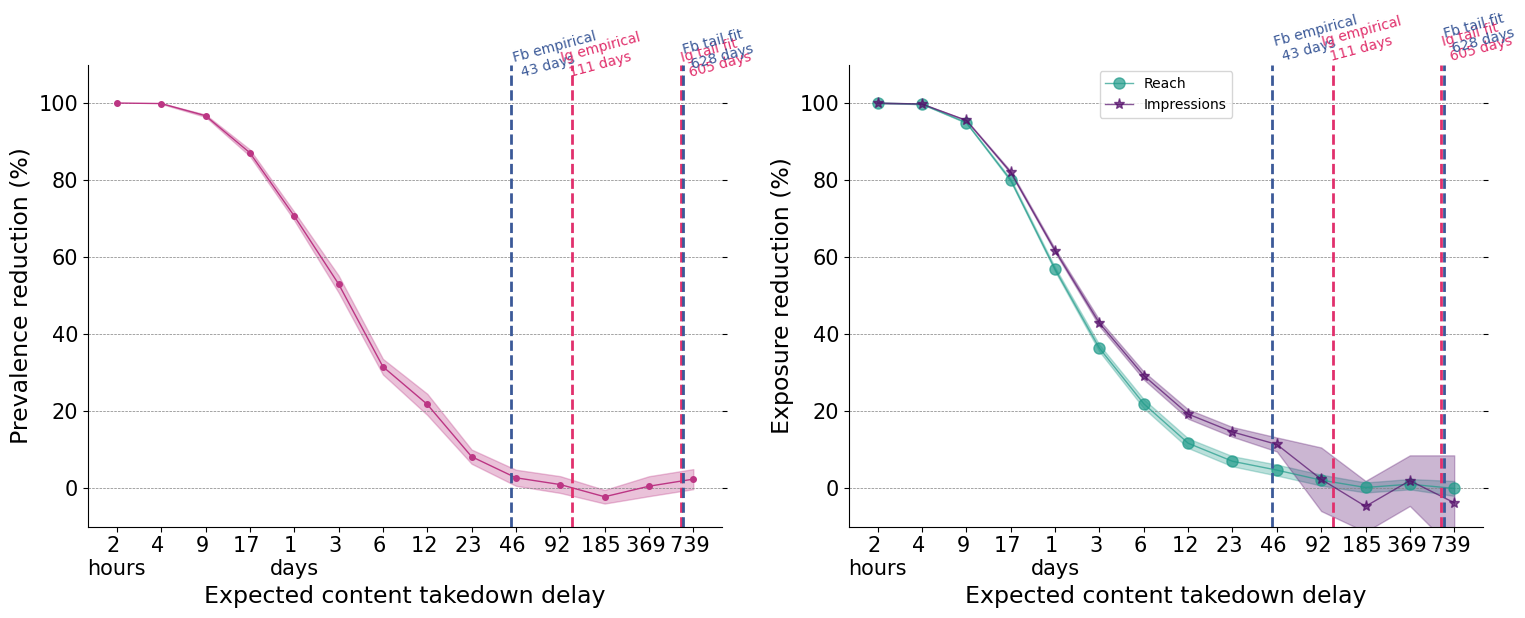

In [ ]:
import matplotlib.pyplot as plt

PALETTE = [
    "#209B8A",  # teal
    "#550F6B",  # purple
    "#3863AC",  # blue
    "#BC3684",  # pink
]
plt.style.use("stylesheet.mplstyle")
fpath = os.path.join(PLOT_DIR, f"main_res_palette4_presentation")

x_col = "half_life"
y_labels = ["Prevalence reduction (%)", "Exposure reduction (%)"]
x_label = "Expected content takedown delay"
pct = True
log_x = True

fig, axs = plt.subplots(
    1, 2, figsize=(18, 6), sharex=True, sharey=True
)  # same size with contour plot
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# PLOT PREVALENCE
plot_data_prevalence = zip(
    *sorted(
        zip(
            np.array(prevalence_plot_data["x"]) / np.log(2),
            prevalence_plot_data["y"],
            prevalence_plot_data["y_lower"],
            prevalence_plot_data["y_upper"],
        ),
        key=lambda x: x[0],
    )
)
draw_lines(
    axs[0],
    plot_data_prevalence,
    line_name="Prevalence",
    marker=".",
    color=PALETTE[-1],
    absolute=True,
)

## PLOT EXPOSURE
ax = axs[1]
# Define the focal metrics and aggregation types
metrics = [
    ("no_reach", "mean"),
    # ("no_unique_reshares", "mean"),
    ("no_exposures", "mean"),
]
labels = [
    "Reach",
    #   "Engagement",
    "Impressions",
]
markers = ["o", "*", "d"]
lines = ["-", "-", "--"]
metric_col = "pct_mean"
# Plot each focal_metric_agg as a line
idx = 0
xticks = None
# x_tickvalues=None
for focal_metric, agg_type in metrics:
    focal_data = exposure_data[f"{focal_metric}_{agg_type}"]

    x = focal_data["mean_lifetime"]
    if idx == 0:
        xticks = focal_data["human_vals"]
    if labels[idx] == "Impression":
        ax = axs[1]
    y = focal_data[f"{metric_col}"] if not pct else focal_data[f"{metric_col}"] * 100
    y_lower = focal_data["lower"] if not pct else focal_data["lower"] * 100
    y_upper = focal_data["upper"] if not pct else focal_data["upper"] * 100
    plot_data = zip(*sorted(zip(x, y, y_lower, y_upper, xticks), key=lambda x: x[0]))

    # Input: data=(x,y, err)
    x, y, y_lower, y_upper, xticks = plot_data
    # plot absolute values
    y = np.array(y) * -1
    y_lower = np.array(y_lower) * -1
    y_upper = np.array(y_upper) * -1
    ax.plot(
        x,
        y,
        marker=markers[idx],
        color=PALETTE[idx],
        linewidth=1,
        linestyle=lines[idx],
        alpha=0.7,
        label=labels[idx],
    )
    ax.fill_between(
        x,
        y_lower,
        y_upper,
        color=PALETTE[idx],
        alpha=0.3,
    )
    idx += 1

    ax.legend(loc="upper center")


# Additional plot settings
from matplotlib.ticker import FixedLocator, FuncFormatter

for kdx, ax in enumerate(axs):
    # Plot dashed lines at specified values with alternating colors
    x_values = [
        # 0.27,
        29.62,
        77,
        419.35,
        435.14,
    ]
    meanlife_values = x_values / np.log(2)
    human_meanlife_values = [
        convert_days_to_nearest_unit(val) for val in meanlife_values
    ]
    country = [
        # "Fb NetzDG",
        "Fb empirical",
        "Ig empirical",
        "Ig tail fit",
        "Fb tail fit",
    ]
    labels = [f"{c} \n {h}" for c, h in zip(country, human_meanlife_values)]
    # Offset values for overlapping labels
    x_offsets = [0, -20, -10, -20, 100]  # Adjust these values as needed
    y_offsets = [0, 0, 0, 2, -10]  # Adjust these values as needed

    for jdx, (x_val, label, x_offset, y_offset) in enumerate(
        zip(meanlife_values, labels, x_offsets, y_offsets)
    ):
        if "Fb" in label:
            color = "#3b5998"
        if "Ig" in label:
            color = "#E1306C"  # purple red
        ax.axvline(x=x_val, color=color, linestyle="--", label=label, linewidth=2)
        # if kdx == 0:
        ax.text(
            x_val + x_offset,
            ax.get_ylim()[1] + y_offset,
            label,
            rotation=15,
            verticalalignment="bottom",
            fontsize=10,
            color=color,
        )

    ax.set_xscale("log", base=2)
    ax.set_ylabel(y_labels[kdx])

    # XLABEL & TICKS FOR BOTH PLOTS
    # Setting for exposure plot
    ax.set_xlabel(x_label)

    custom_xticks = x
    # if the x is the first element in xticks contains "hours", keep the same, else remove "hours" from x
    custom_xtick_labels = []
    first_hour = False
    first_day = False
    for idx, xtick in enumerate(xticks):
        if "hours" in xtick and not first_hour:
            custom_xtick_labels.append(xtick)
            first_hour = True
        elif "days" in xtick and not first_day:
            custom_xtick_labels.append(xtick)
            first_day = True
        else:
            custom_xtick_labels.append(xtick.split("\n")[0])

    ## NOTE: Set y-axis limits to eliminate the big CI. DELETE THIS LATER
    ax.set_ylim(-10, 110)

    ax.xaxis.set_major_locator(FixedLocator(custom_xticks))
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: custom_xtick_labels[custom_xticks.index(x)])
    )
    # if kdx == 0:
    #     ax.set_xticklabels([])
    ax.tick_params(
        labelleft=True,
        labelright=False,
        left=True,
        right=True,
    )

    # Hide spines
    ax.spines.right.set_visible(False)
    ax.spines.top.set_visible(False)

    ax.grid(True, axis="y", linestyle="--", linewidth=0.5, color="grey")

# plt.tight_layout()

plt.savefig(f"{fpath}.png", dpi=300, bbox_inches="tight")
plt.savefig(f"{fpath}.pdf", dpi=300)
plt.show()